In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from functools import partial
import random
from scipy import ndimage

In [2]:
(test_set_raw, val_set_raw, train_set_raw), info = tfds.load("tf_flowers", split=["train[:10%]", "train[10%:25%]", "train[25%:]"], as_supervised=True, with_info=True)

In [3]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
info.splits["train"].num_examples

3670

In [4]:
def preprocess(image, label, augment=False):
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        
    image = tf.image.resize(image, [256, 256])
    image = tf.keras.layers.CenterCrop(224, 224)(image)
    image = keras.applications.xception.preprocess_input(image)
    return image, label

In [5]:
train_set = train_set_raw.map(partial(preprocess, augment=True)).batch(32).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(32).prefetch(1)
val_set = val_set_raw.map(preprocess).batch(32).prefetch(1)

In [6]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                 include_top=False)

for layer in base_model.layers:
    layer.trainable = False
    
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
hidden_l1 = keras.layers.Dense(256, activation="relu")(avg)
dropout = keras.layers.Dropout(rate=0.4)(hidden_l1)
output = keras.layers.Dense(n_classes, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.inputs, outputs=output)

In [7]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
)

# Reduce learning rate when validation loss plateaus
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5
)

In [8]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [9]:
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * 3670 / 32),
                    validation_data=val_set,
                    validation_steps=int(0.15 * 3670 / 32),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 107s 1s/step - loss: 0.5493 - accuracy: 0.7943 - val_loss: 0.3600 - val_accuracy: 0.8676
Epoch 2/5
86/86 [==============================] - 107s 1s/step - loss: 0.3044 - accuracy: 0.8921 - val_loss: 0.3568 - val_accuracy: 0.8768
Epoch 3/5
86/86 [==============================] - 107s 1s/step - loss: 0.2280 - accuracy: 0.9168 - val_loss: 0.3490 - val_accuracy: 0.8805
Epoch 4/5
86/86 [==============================] - 107s 1s/step - loss: 0.1929 - accuracy: 0.9281 - val_loss: 0.3709 - val_accuracy: 0.8713
Epoch 5/5
86/86 [==============================] - 113s 1s/step - loss: 0.1700 - accuracy: 0.9422 - val_loss: 0.3846 - val_accuracy: 0.8768


In [10]:
model.evaluate(test_set)

12/12 [==============================] - 13s 1s/step - loss: 0.3188 - accuracy: 0.8910


[0.3188232481479645, 0.891008198261261]

In [11]:
history.history["accuracy"]
history.history["val_accuracy"]

[0.8676470518112183,
 0.876838207244873,
 0.8805146813392639,
 0.8713235259056091,
 0.876838207244873]

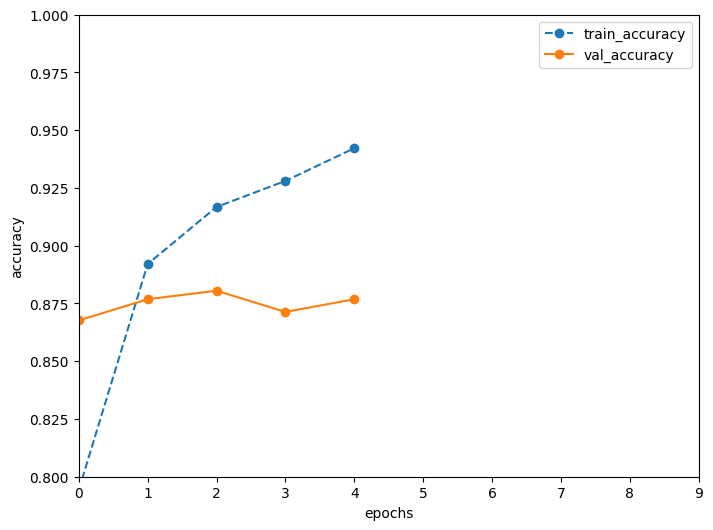

In [13]:
epochs = np.arange(5)
plt.figure(figsize=(8,6))
plt.plot(epochs,history.history["accuracy"],"o--", label="train_accuracy")
plt.plot(epochs,history.history["val_accuracy"], "o-", label="val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.axis([0,9,0.8,1])
plt.legend()

In [14]:
for layer in base_model.layers:
    layer.trainable = True

In [15]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * 3670 / 32),
                    validation_data=val_set,
                    validation_steps=int(0.15 * 3670 / 32),
                    epochs=40)

Epoch 1/40
 8/86 [=>............................] - ETA: 8:30 - loss: 0.4953 - accuracy: 0.8242

KeyboardInterrupt: 